In [1]:
import numpy as np
import sys
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
import torch
from skorch import NeuralNetRegressor
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from data import load_narx_data
from model import Narx

In [22]:
n_epochs=int(5e2)
na_list=[*range(3,8)]
nb_list=[*range(14,26)]
final_losses=np.ndarray((len(na_list),len(nb_list)))
final_best_RMSs=np.ndarray((len(na_list),len(nb_list)))

In [23]:
for i, na in enumerate(na_list):
    for j, nb in enumerate(nb_list):
        x,y = load_narx_data(na, nb)
        x_train, x_val, y_train, y_val =train_test_split(x, y)
        n_hidden_nodes= na+nb
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x_train, x_val, y_train, y_val=[x.to(device) for x in [x_train, x_val, y_train, y_val]]
        best_RMS=float('inf')
        best_model=None
        losses=[]
        RMSs=[]
        best_RMSs=[]

        model = Narx(x_train.shape[1], n_hidden_nodes).to(device) #a=)
        optimizer = torch.optim.Adam(model.parameters()) #a)
        for epoch in range(n_epochs): #a)
            Loss = torch.mean((model(x_train)-y_train)**2) #a)
            optimizer.zero_grad() #a)
            Loss.backward() #a)
            optimizer.step() #a)
            if (epoch+1)%min((n_epochs//20),1000)==0: #a) monitor
                print(f"current run: {na, nb}, epoch: {epoch+1}, Loss: {Loss.item()}") #a)
                RMS=np.mean((y_val.detach().cpu().numpy()-model.forward(x_val).detach().cpu().numpy())**2)**0.5
                if RMS < best_RMS:
                    best_RMS=RMS
                    best_model=deepcopy(model)
                    print(f"current RMS: {RMS}, best RMS: {best_RMS}")
                losses.append(Loss.item())
                RMSs.append(RMS)
                best_RMSs.append(best_RMS)
        final_losses[i,j]=losses[-1]
        final_best_RMSs[i,j]=best_RMSs[-1]


current run: (3, 14), epoch: 25, Loss: 0.18446444106520646
current RMS: 0.4228542612549339, best RMS: 0.4228542612549339
current run: (3, 14), epoch: 50, Loss: 0.1403700326187963
current RMS: 0.36899802153848854, best RMS: 0.36899802153848854
current run: (3, 14), epoch: 75, Loss: 0.11296721161922153
current RMS: 0.3311720021774745, best RMS: 0.3311720021774745
current run: (3, 14), epoch: 100, Loss: 0.09815578344365539
current RMS: 0.3090135341518158, best RMS: 0.3090135341518158
current run: (3, 14), epoch: 125, Loss: 0.08903484528455428
current RMS: 0.294413536438985, best RMS: 0.294413536438985
current run: (3, 14), epoch: 150, Loss: 0.08101224110291806
current RMS: 0.28076456989484977, best RMS: 0.28076456989484977
current run: (3, 14), epoch: 175, Loss: 0.07267791565327185
current RMS: 0.2658021994997242, best RMS: 0.2658021994997242
current run: (3, 14), epoch: 200, Loss: 0.0640762283791962
current RMS: 0.2494292328214926, best RMS: 0.2494292328214926
current run: (3, 14), epoch

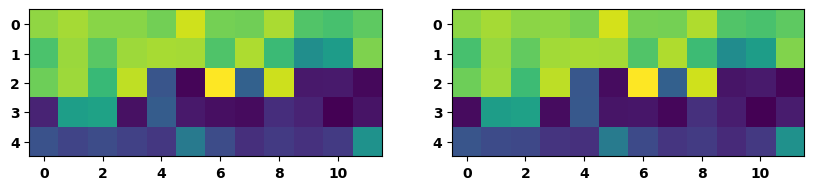

In [24]:
fig = plt.figure(figsize=(10, 10))
ax1=fig.add_subplot(121)
ax1.imshow(final_losses, interpolation='none', norm='log')
ax2=fig.add_subplot(122)
ax2.imshow(final_best_RMSs, interpolation='none', norm='log')


In [47]:
min_arg = np.unravel_index(final_best_RMSs.argmin(keepdims=True), final_best_RMSs.shape)
params = np.zeros((len(na_list), len(nb_list), 2))
for i, na in enumerate(na_list):
    for j, nb in enumerate(nb_list):
        params[i, j, :] = [na, nb]

best_na, best_nb = params[min_arg].ravel()

In [ ]:
skorch_narx = NeuralNetRegressor(
    module=Narx, optimizer=torch.optim.Adam, criterion=torch.nn.MSELoss()
)

In [ ]:
params={'module__n_hidden':[]}